In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA

## Load Dataset
Note: Targets[8] is neutral data

In [2]:
dataset_name = "recordings/simple_recording_sultan_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    targets[i]['Unnamed: 0'] = [i % 129 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of       Counter        P7        O1        O2        P8          TIME
0           0  4619.487  3976.410  3911.795  4177.949  1.604692e+09
1           1  4615.385  3970.769  3903.590  4170.256  1.604692e+09
2           2  4606.667  3969.744  3893.846  4166.667  1.604692e+09
3           3  4605.641  3970.256  3895.897  4168.718  1.604692e+09
4           4  4616.923  3971.282  3898.974  4168.205  1.604692e+09
...       ...       ...       ...       ...       ...           ...
3195       99  4597.436  3953.333  3864.615  4253.846  1.604692e+09
3196      100  4597.949  3953.846  3868.205  4254.872  1.604692e+09
3197      101  4595.897  3953.846  3875.385  4259.487  1.604692e+09
3198      102  4590.256  3946.154  3873.846  4258.462  1.604692e+09
3199      103  4587.179  3938.974  3867.179  4249.744  1.604692e+09

[3200 rows x 6 columns]>

In [3]:
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

length target 0 = 3200
length target 1 = 3200
length target 2 = 3200
length target 3 = 3200


##  Filtering, Averaging, and Plotting Functions

In [4]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(8)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))



# these filtering functions work on each target - only call once
def pca_filter(variance=0.2):
    for i in range(num_targets):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(frequencies=None):
    
    if frequencies is None:
        filt = signal.firwin(400, [1.0, 50.0], pass_zero=False, fs=128.0)
        for i in range(num_targets):
            for channel in channels:
                targets[i][channel] = signal.convolve(np.array(targets[i][channel]), filt, mode='same')
    # trying to filter each channel based on respective target frequencies
    else:
        for i in range(num_targets):
            band_edges = [frequencies[i]-1.0, frequencies[i]+1.0]
            print(band_edges)
            for channel in channels:
                filt = signal.firwin(400, band_edges, pass_zero=False, fs=128.0)
                targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
        
def plot_time_all(start=0, end=1000):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            targets[i][channel][start:end].plot(y=channel, title='Target {} Signal Over Time'.format(i) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        # ax.set_xlim(start, end)
        ax.autoscale(axis='y', tight=True)
        
        
def plot_channel(target, channel):
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def cut_left_end(cutoff=256):
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
        
def plot_averages():
    # plot all targets all channels on one plot. possibly messy
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, avg_sig in enumerate(averages_all_targets):
        for channel in channels:
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i] if channel=='P7' else "")
    ax.legend()
    ax.set_title('Average Signals for All Targets and All Channels')
    
def plot_target_average(ind):
    # all channels for one target - input is index of targets
    fig, ax = plt.subplots(figsize=(15, 7))
    for j, channel in enumerate(channels):
        averages_all_targets[ind].plot(x='Counter', y=channel, ax=ax, color=my_colors[j], label=channel)
    ax.set_title('Target {} Average Signal for All Channels'.format(ind) if ind != 8 else 'Neutral Target Average Signal for All Channels')
        
def plot_averages_by_channel():
    # 4 plots, each with 8 targets + neutral
    for channel in channels:
        fig, ax = plt.subplots(figsize=(15, 7))
        for i, avg_sig in enumerate(averages_all_targets):
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i])
        ax.legend(loc='upper right')
        ax.set_title('Channel {} Average Signals for All Targets'.format(channel))


def averaging():
    averages = []
    cols = ['Counter', 'O1', 'O2', 'P7', 'P8']
    for target in targets:
        average_for_target = pd.DataFrame(columns = cols)
        for i in range(128):
            o1avg = np.average(target.query('Counter == {}'.format(i))['O1'])
            o2avg = np.average(target.query('Counter == {}'.format(i))['O2'])
            p7avg = np.average(target.query('Counter == {}'.format(i))['P7'])
            p8avg = np.average(target.query('Counter == {}'.format(i))['P8'])
            row = {'Counter' : i, 'O1' : o1avg, 'O2' : o2avg, 'P7' : p7avg, 'P8' : p8avg}
            average_for_target = average_for_target.append(row, ignore_index=True)
        
        averages.append(average_for_target)
    return averages
    

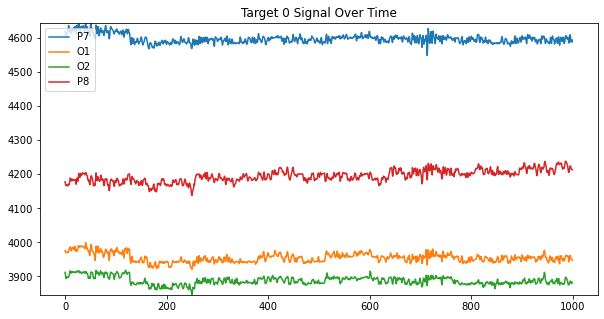

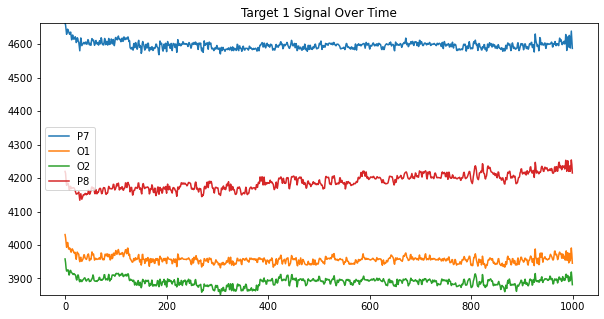

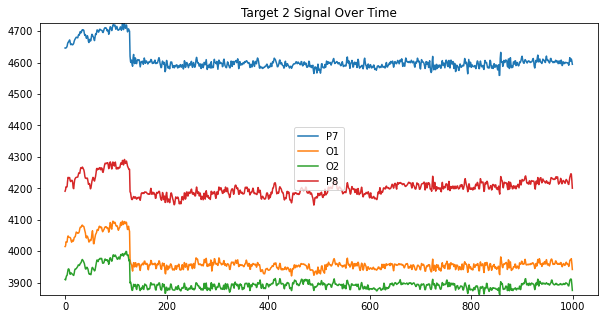

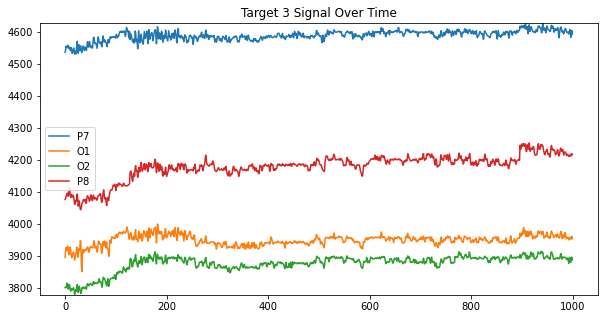

In [5]:
plot_time_all()

In [6]:
frequencies = [32.0, 25.6, 21.33, 18.28]
# if not passing in frequencies, default settings
fir_filter()
fir_filter(frequencies)

[31.0, 33.0]
[24.6, 26.6]
[20.33, 22.33]
[17.28, 19.28]


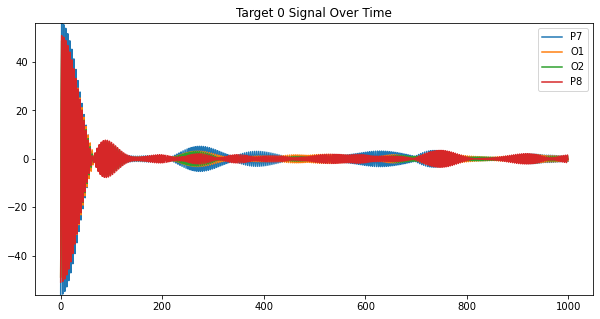

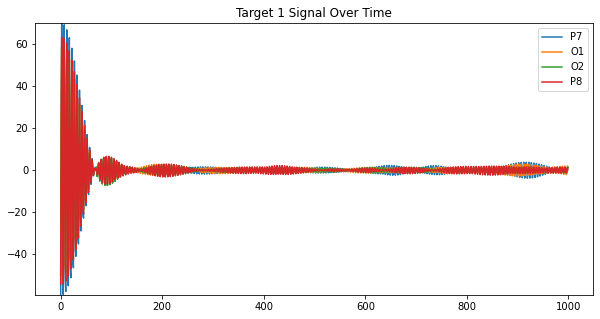

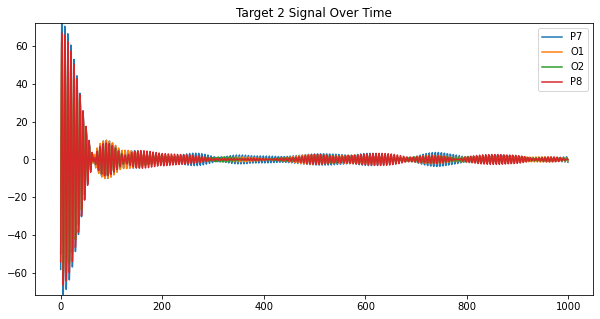

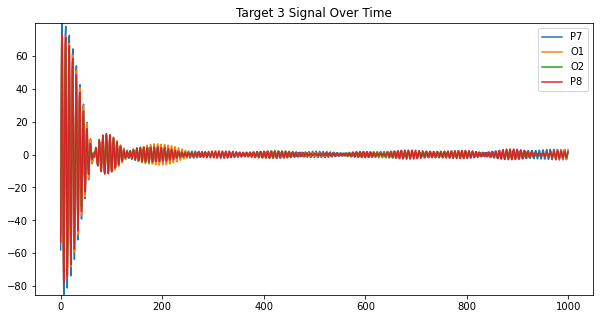

In [7]:
plot_time_all()

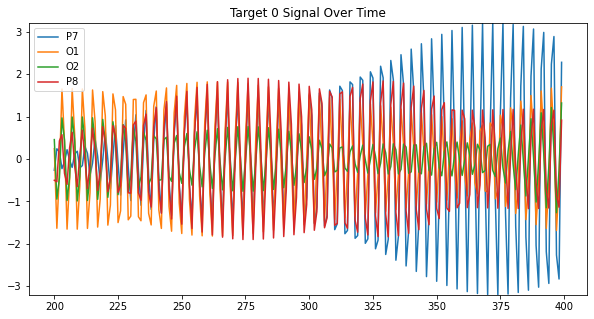

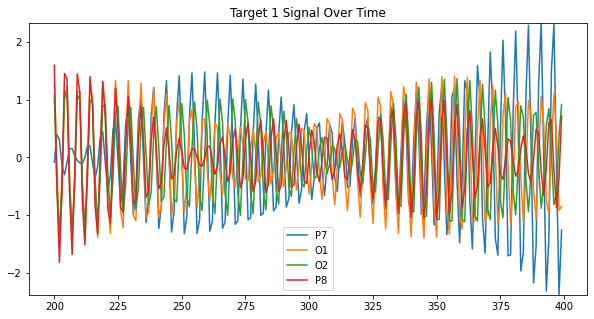

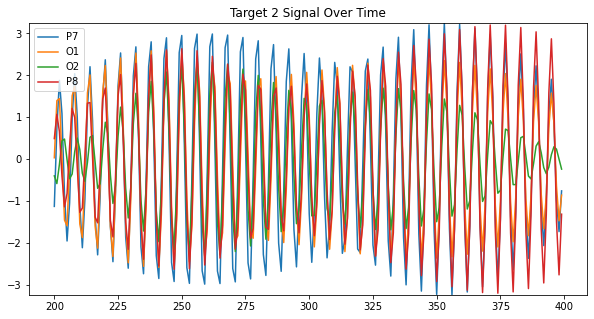

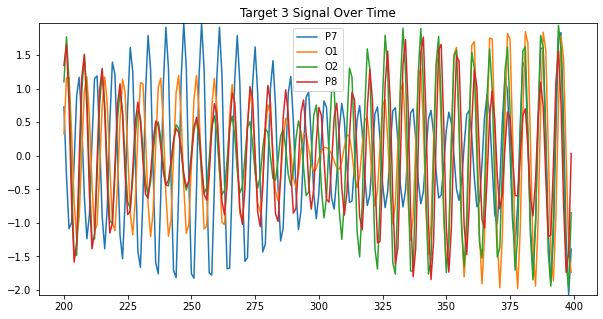

In [8]:
cut_left_end(cutoff=256)
plot_time_all(start=200, end=400)

In [28]:
# try averaging
# averages_all_targets = averaging()

In [29]:
# for i in range(num_targets):
    # plot_target_average(i)

## Generate CCA Features 
 2 canonical correlations x 4 targets x 2 harmonics = 16 features

In [23]:
def getReferenceSignals(frequencies):
    ref_signals = []
    for freq in frequencies:
        ref_signals.append(generateRefSignal(128, freq))
    return np.asarray(ref_signals)

def generateRefSignal(samples, freq):
    signals = []
    t = np.arange(0, (samples/128.0), step=1.0/128.0)
    signals.append(np.sin(np.pi*2*freq*t))
    signals.append(np.cos(np.pi*2*freq*t))
    signals.append(np.sin(np.pi*4*freq*t))
    signals.append(np.cos(np.pi*4*freq*t))

    return np.asarray(signals)

def findCorr(data, target, print_corrs=False):
    result = np.zeros((target.shape)[0])
    cca = CCA(n_components=1)
    for i in range(0, (target.shape)[0]):
        cca.fit(data, np.squeeze(target[i,:,:]).T)
        a, b = cca.transform(data, np.squeeze(target[i,:,:]).T)
        corr = np.corrcoef(a[:,0], b[:,0])[0, 1]
        if print_corrs:
            print('\t\t\tCorrelation with target {} = {}'.format(i, corr))
        result[i] = corr
    return result

def predict(data, ref_signals, print_corrs=False):
    corrs = findCorr(data, ref_signals, print_corrs=True)
    prediction = np.argmax(corrs)
    print("Predicted target {}".format(prediction))
    
    
ref_signals = getReferenceSignals(frequencies)

In [26]:
# check on target 0 data 
def check_targets():
    channels = ['P7', 'O1', 'O2', 'P8']
    for target in range(len(targets)):
        row = 0
        print('\n' + '-'*20 + 'Checking Target {} against reference signals ...'.format(target) + '-'*20 + '\n')
        while True:
            if row >= len(targets[target].index):
                break
            print('Checking samples {} to {} ...'.format(row, row+128))
            data = np.asarray(targets[target][channels][row:row+128])
            predict(data, ref_signals, print_corrs=True)
            row += 128

In [27]:
check_targets()


--------------------Checking Target 0 against reference signals ...--------------------

Checking samples 0 to 128 ...
			Correlation with target 0 = 0.9937670294201855
			Correlation with target 1 = 0.12732022711897586
			Correlation with target 2 = 0.08513506573310743
			Correlation with target 3 = 0.17231807474493377
predicted target 0
Checking samples 128 to 256 ...
			Correlation with target 0 = 0.8161385657942521
			Correlation with target 1 = 0.08371515774766007
			Correlation with target 2 = 0.06969645219509014
			Correlation with target 3 = 0.11831894723694683
predicted target 0
Checking samples 256 to 384 ...
			Correlation with target 0 = 0.9827037234216712
			Correlation with target 1 = 0.09362560452659097
			Correlation with target 2 = 0.0760770356917889
			Correlation with target 3 = 0.1445746993799241
predicted target 0
Checking samples 384 to 512 ...
			Correlation with target 0 = 0.9928454447518924
			Correlation with target 1 = 0.08123545711081764
			Correlation with

			Correlation with target 0 = 0.11285949555693689
			Correlation with target 1 = 0.9908453142609162
			Correlation with target 2 = 0.11003908719527894
			Correlation with target 3 = 0.07356476844889226
predicted target 1
Checking samples 1280 to 1408 ...
			Correlation with target 0 = 0.12128756744205814
			Correlation with target 1 = 0.960380231573784
			Correlation with target 2 = 0.1376282835231815
			Correlation with target 3 = 0.08987022635747685
predicted target 1
Checking samples 1408 to 1536 ...
			Correlation with target 0 = 0.06195014316132336
			Correlation with target 1 = 0.9588404679025337
			Correlation with target 2 = 0.10926281357378395
			Correlation with target 3 = 0.07857414851381636
predicted target 1
Checking samples 1536 to 1664 ...
			Correlation with target 0 = 0.07641224327828391
			Correlation with target 1 = 0.8381498891858743
			Correlation with target 2 = 0.15648792549510232
			Correlation with target 3 = 0.10349371241231631
predicted target 1
Checking sam

			Correlation with target 0 = 0.07984765593549252
			Correlation with target 1 = 0.13476827700553962
			Correlation with target 2 = 0.8702451836287574
			Correlation with target 3 = 0.18358872458146272
predicted target 2
Checking samples 2816 to 2944 ...
			Correlation with target 0 = 0.06716981596496434
			Correlation with target 1 = 0.14378204498860273
			Correlation with target 2 = 0.9839719538506583
			Correlation with target 3 = 0.13864825514388193
predicted target 2

--------------------Checking Target 3 against reference signals ...--------------------

Checking samples 0 to 128 ...
			Correlation with target 0 = 0.22901882675415208
			Correlation with target 1 = 0.12878817678008964
			Correlation with target 2 = 0.30965013697754473
			Correlation with target 3 = 0.8942857197956081
predicted target 3
Checking samples 128 to 256 ...
			Correlation with target 0 = 0.08664816770773463
			Correlation with target 1 = 0.046818184209027384
			Correlation with target 2 = 0.130779045438

## KNN Classification

In [ ]:
# soon